# Are there peas in binary pods?
## Comparing the peas-in-a-pod architecture in single and binary star systems

--------------------------------------------------------------------------------------------------

## Introduction

Exoplanet surveys have established that planet formation is a common outcome of star formation, producing a diverse population of planetary systems that extends well beyond the architecture of the Solar System. Statistical studies show that small planets, like super-Earths and sub-Neptunes, dominate the exoplanet population, particularly at short orbital periods, while gas giants are comparatively rare and strongly correlated with host-star metallicity (Howard et al. 2012; Petigura et al. 2013; Fulton et al. 2017). The difference in these populations hint at the fact that planet formation is linked to stellar properties like mass and metallicity.

Results from Kepler show that planets do not form in isolation. Multiplanet systems are common and often dynamically stable, with low mutual inclinations and nearly circular orbits (Lissauer et al. 2011; Fabrycky et al. 2014), in compact configurations with regular orbital spacing.

Moreso, planets frequently exhibit correlated properties, including similar radii, masses, and orbital spacings—an effect known as the **peas-in-a-pod** phenomenon (Weiss et al. 2018; Millholland et al. 2017). Multiplanet systems therefore provide a powerful framework for probing planet formation and evolution. 

Nonetheless, even though surveys tend to control for stellar properties (meaning, there is an underlying selection for stars with specific masses or metallicities), binarity is sometimes ignored, both for how difficult it is to find binary companions, and because the effects of a secondary star are not well constrained yet (Kraus et al. 2016, Ziegler et al. 2018). With the arrival of Gaia we have been able to find and confirm more binary stars than ever (El-Badry et al. 2021), and it has been shown that multiplicity is a very important factor in star formation.

Because of this, in this project I attempt to compare the population of known peas-in-a-pod (PIAP) systems to those that host a second star, to see how well the populations match eachother, or in the contrary, how much they differ. 

In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.font_manager as fm
from scipy.stats import ks_2samp


plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (6,6)

plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12


_________________________________

## Data Analysis

To do this, I make use of the [Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/). The full confirmed exoplanets catalogue was downloaded on November 10, 2025.  

In [2]:
exoplanetarchive = pd.read_csv('PS_2025.11.10_13.06.39.csv', low_memory = False)
exoplanetarchive = exoplanetarchive[exoplanetarchive.default_flag == 1]
exoplanetarchive.fillna({'gaia_dr3_id': -9999})
exoplanetarchive['DR3_id'] = [str(exoplanetarchive.iloc[i]['gaia_dr3_id']).split(' ')[-1] for i in range(len(exoplanetarchive))]

Here I have just loaded the catalogue, selected default_flag as 1 to ensure that planets are not duplicated, and filled nan values to ensure that I can safely select stars that have Gaia IDs later on. I have also made sure that the ID is in the correct format to crossmatch with other catalogues.

### <u>California Kepler Survey</u>

I started by performing a crossmatch of all the systems in the California Kepler Survey (Weiss et al. 2018) with Gaia DR3 using Topcat. Since the database from the CKS paper included the source IDs, that is what I used to find the missing information from Gaia. From this, I get 896 planets around 351 stars.

In [3]:
cks = pd.read_csv('CKSxGaia.csv')
cks['dr3_id'] = [cks.loc[i,'DR3Name'].split(' ')[2] for i in range(len(cks))]
cks = cks.sort_values(by=['M*']).reset_index().drop(columns = ['index'])

These systems have a well known architecture, called **peas in a pod**. This means that the planets around a star tend to have similar sizes (since these are transiting planets, we know their radii), and are equally spaced in logarithmic scale. 

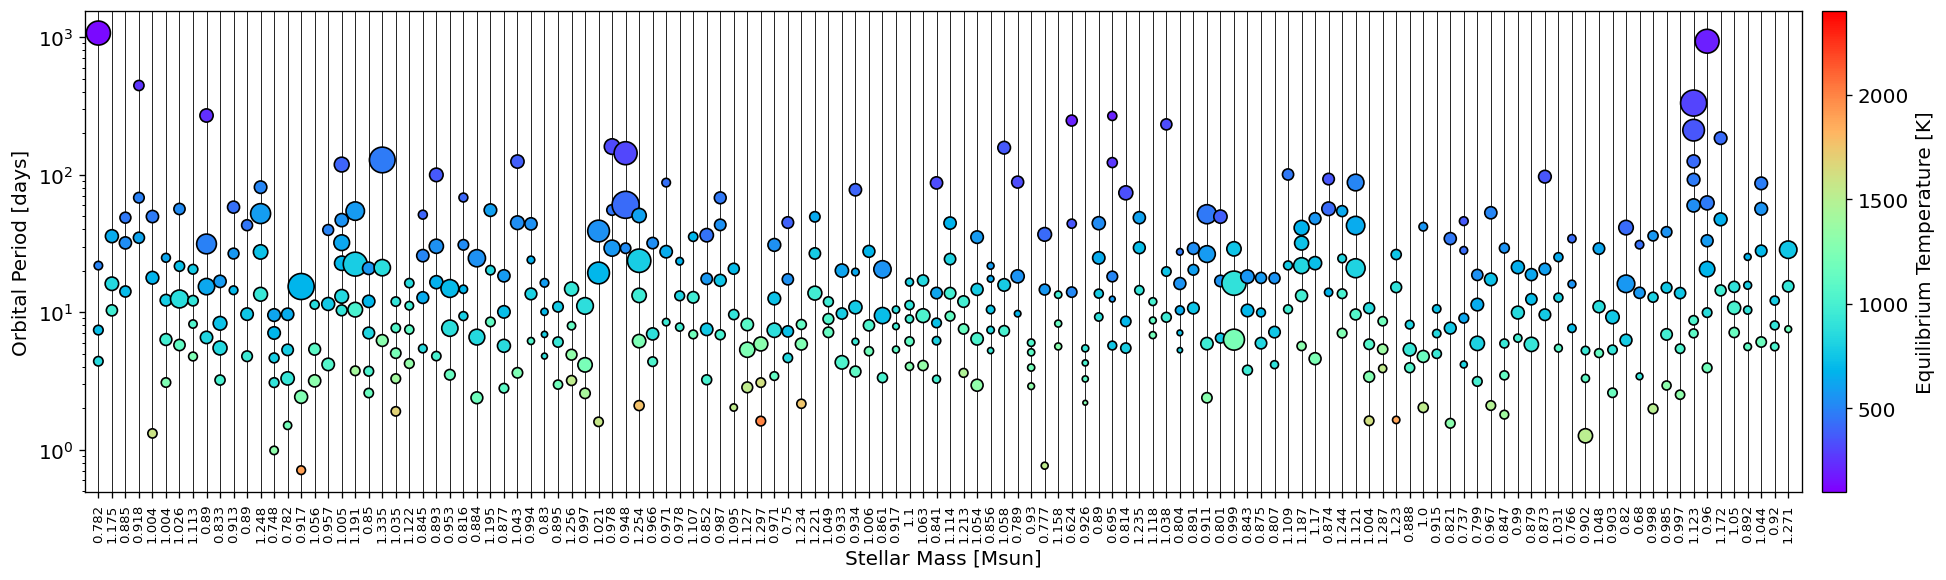

In [4]:
star_masses = []
ids = []

plt.figure(figsize = (18, 5))

i = 0

for gaiadr3_id in np.unique(cks['dr3_id']):
    
    planet_rad = cks[cks.dr3_id == gaiadr3_id]['Rp']
    planet_sep = cks[cks.dr3_id == gaiadr3_id]['Per']
    planet_temp = cks[cks.dr3_id == gaiadr3_id]['Teq']
   
    star_mass = cks[cks.dr3_id == gaiadr3_id]['M*'].iloc[0]#[*sys_summary[gaiadr3_id].st_mass.values()]

    if len(planet_rad) > 2:
        plt.axvline(i*10, 0, 1, zorder = -1, color = 'k', linewidth = 0.5)#, markersize = 25, cmap = 'rainbow', c = planet_mass)
        plt.scatter([i*10]*len(planet_rad), planet_sep, planet_rad*20, cmap = 'rainbow', c = planet_temp, vmin = 100, vmax = 2400, edgecolor = 'k')
        
        ids.append(i*10)
        star_masses.append(star_mass)
        i+= 1

plt.xlim(-10, i*10)
plt.gca().xaxis.set_ticks(ids, star_masses, rotation = 90, size = 8)
plt.yscale('log')

plt.ylabel('Orbital Period [days]')
plt.xlabel('Stellar Mass [Msun]')
plt.colorbar(label = 'Equilibrium Temperature [K]', pad = 0.01)
plt.tight_layout()
plt.show()


The previous figure shows that these two properties are very noticeable for most of the systems. While this representation is useful to characterize individual systems, we can also check that the sizes and spacings are correlated by looking at the full sample of planets. 


#### Planet Radii
In order to get a general view of these architectures we can start by analysing how correlated the radii in the systems are. To do this, we can compare the sizes of consecutive planets. It is important to note that to follow the analysis of Weiss et al. 2018, I only considered pairs of planets where both were equal or smaller than 4 Rearth, as well as systems with 3 planets or more.

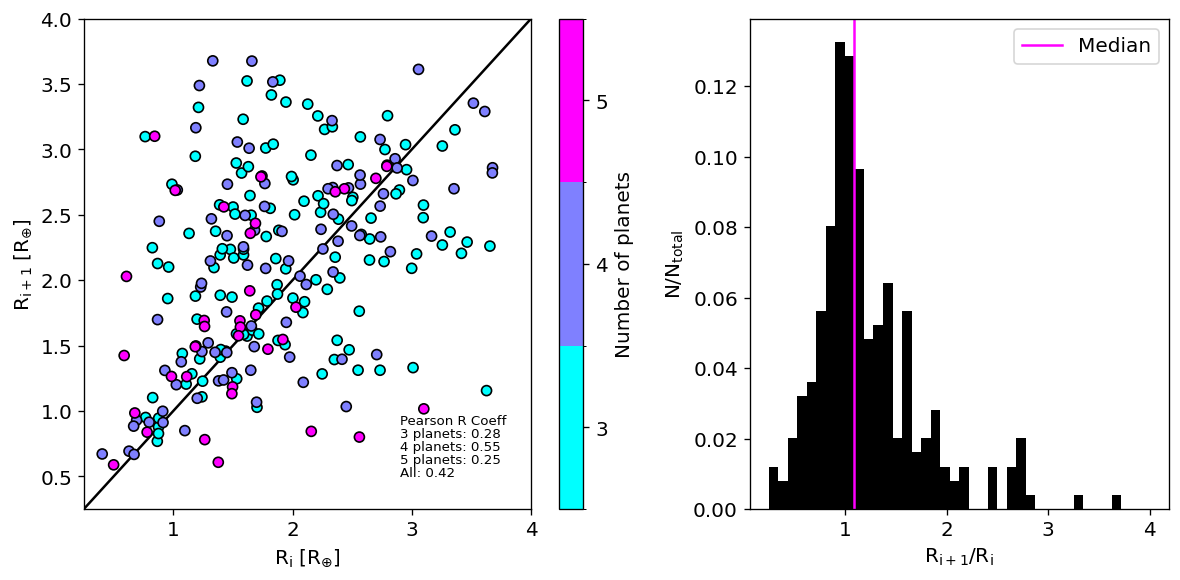

In [5]:
i_planets = {}
iplus1_planets = {}
i_planets['all'] = []
iplus1_planets['all'] = []


cmap = plt.cm.cool
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(3,6,4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)




fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5), width_ratios = [4,3])

for planets_in_system in range(3,7):
    
    i_planets[planets_in_system] = []
    iplus1_planets[planets_in_system] = []
    
    for star, system in cks.groupby('dr3_id'):
        
        planet_rad = system.sort_values('Per')['Rp']
                
        if len(planet_rad) == planets_in_system and (np.sum(planet_rad >= 4) < 1):               
           sc = axs[0].scatter(planet_rad.iloc[:-1], np.asarray(planet_rad.iloc[1:]),
                       cmap = cmap, 
                       c = np.ones(len(planet_rad)-1)*len(planet_rad), 
                       norm=norm,
                       #vmin = 3, vmax = 6
                      edgecolor = 'k')
           
           i_planets[planets_in_system].append(planet_rad.iloc[:-1])
           iplus1_planets[planets_in_system].append(planet_rad.iloc[1:])

           i_planets['all'].append(planet_rad.iloc[:-1])
           iplus1_planets['all'].append(planet_rad.iloc[1:])

axs[0].text(2.9, 0.9, f'Pearson R Coeff', fontsize = 8)
axs[0].text(2.9, 0.8, f'3 planets: {round(pearsonr(np.concatenate(i_planets[3]), np.concatenate(iplus1_planets[3]))[0],2)}', fontsize = 8)
axs[0].text(2.9, 0.7, f'4 planets: {round(pearsonr(np.concatenate(i_planets[4]), np.concatenate(iplus1_planets[4]))[0],2)}', fontsize = 8)
axs[0].text(2.9, 0.6, f'5 planets: {round(pearsonr(np.concatenate(i_planets[5]), np.concatenate(iplus1_planets[5]))[0],2)}', fontsize = 8)

mask = (np.concatenate(i_planets['all']) <= 4)
axs[0].text(2.9, 0.5, f'All: {round(pearsonr(np.concatenate(i_planets['all'])[mask], np.concatenate(iplus1_planets['all'])[mask])[0],2)}', fontsize = 8)

axs[0].set_xlim(0.25, 4)
axs[0].set_ylim(0.25, 4)

cbar = fig.colorbar(sc, ax = axs[0], label = 'Number of planets', ticks = [3.5, 4.5, 5.5, 6.5])
cbar.ax.set_yticklabels(labels = [3, 4, 5, 6])


axs[0].plot([0,13], [0,13], color = 'k', zorder = -1)
axs[0].set_ylabel('R$_{\\mathrm{i+1}}$ [R$_{\\oplus}$]')
axs[0].set_xlabel('R$_{\\mathrm{i}}$ [R$_{\\oplus}$]')



axs[1].hist(np.concatenate(iplus1_planets['all'])/np.concatenate(i_planets['all']), bins = 40, range = (0.25,4), 
            weights = np.ones(len(np.concatenate(i_planets['all'])))/len(np.concatenate(i_planets['all'])), color = 'k')

axs[1].axvline(np.median(np.concatenate(iplus1_planets['all'])/np.concatenate(i_planets['all'])), 
              0,1,
              color = 'magenta', label = 'Median')

axs[1].legend()
axs[1].set_xlabel('R$_{\\mathrm{i+1}}$/R$_{\\mathrm{i}}$')

axs[1].set_ylabel('N/N$_\\mathrm{total}$')




plt.tight_layout()
plt.show()

From this plot we can see that indeed the radii are correlated. In the left panel we can see that most systems fall close to the 1-to-1 curve. Here, the points are colored by the total number of planets in the systems, and as it is possible to see, there are no systems with 3 planets that comply with the constraints we have placed. Also, systems with 4 planets are the most common, and dominate the statistics. In this same panel I have also added the Pearson R coefficient, which is used commonly to see how correlated two variables are; the closer to 1 it is, the more correlated. In this case, we get a value of 0.42 when considering all systems. However, this value increases when considering planets with 4 planets, reaching 0.55, which shows that there might be a positive correlation. There is a large scatter still, but overall the trend seems to be present. It is important to note that Pearson's r is very sensitive to outliers and caon only probe lienar correlations. Nonetheless, it is enough to show the overall behavior of these systems.

In the right panel I have included the distribution of radius ratios, meaning the values of y/x from the left panel. Here we can see that the peak of the distribution is close to 1, with a median that falls at ~1.1. Overall, the ratios seem to scatter around 1, indicating that radii are similar between consecutive planets.

#### Planet Periods

In the same fashion as for the radii, we can compare the spacing between planets to see if its regular by checking the correlation between period ratios between consecutive planets. For this, I have placed the same constrains that I had for the previous sample, that is, three or more planets per system, and pairs where both planets are larger than 4 Rearth.

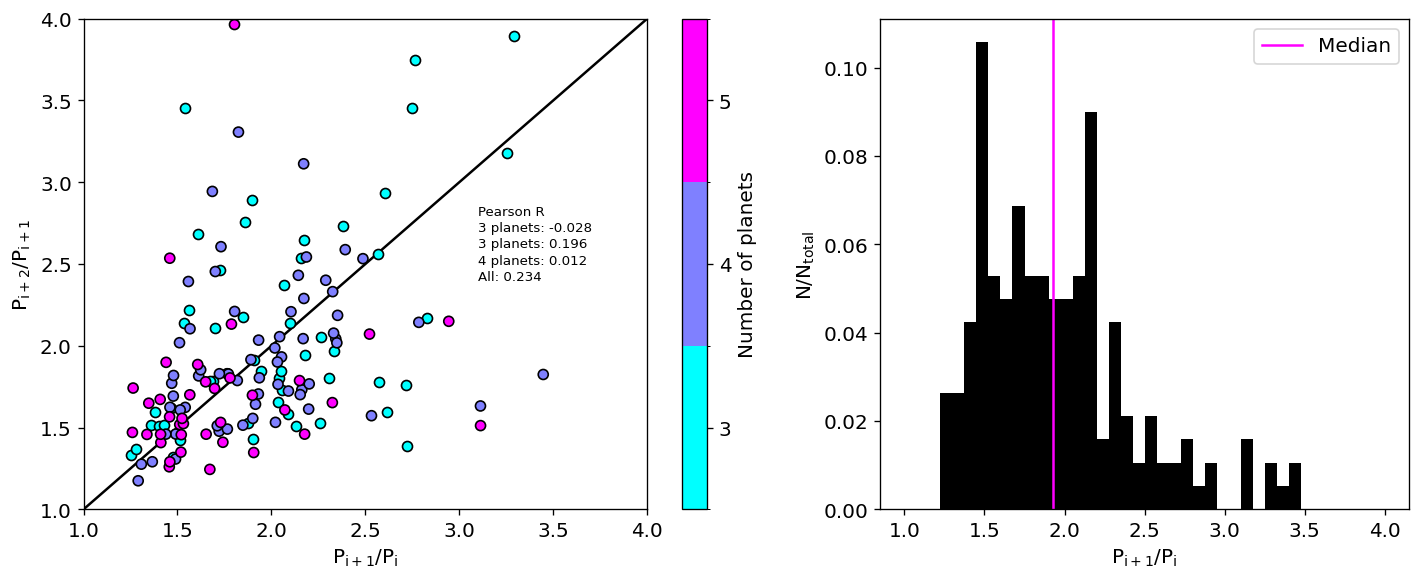

In [6]:
i_planets_per = {}
iplus1_planets_per = {}
i_planets_per['all'] = []
iplus1_planets_per['all'] = []

cmap = plt.cm.cool
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(3,6,4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5), width_ratios = [4,3])



for planets_in_system in range(3,7):
    
    i_planets_per[planets_in_system] = []
    iplus1_planets_per[planets_in_system] = []
    
    for star, system in cks.groupby('dr3_id'):
        
        planet_per= system.sort_values('Per')['Per']
            
        if len(planet_per) == planets_in_system and (np.sum(cks[cks.dr3_id == gaiadr3_id].sort_values(by = 'Per')['Rp'] >= 4) < 1):   
            
           sc = axs[0].scatter(np.asarray(planet_per.iloc[1:-1])/np.asarray(planet_per.iloc[:-2]), np.asarray(planet_per.iloc[2:])/np.asarray(planet_per.iloc[1:-1]),
                       cmap = cmap, 
                       c = np.ones(len(planet_per)-2)*len(planet_per), 
                       norm=norm,
                       #vmin = 3, vmax = 6
                       edgecolor = 'k')
           
           i_planets_per[planets_in_system].append(np.asarray(planet_per.iloc[1:-1])/np.asarray(planet_per.iloc[:-2]))
           iplus1_planets_per[planets_in_system].append(np.asarray(planet_per.iloc[2:])/np.asarray(planet_per.iloc[1:-1]))

           i_planets_per['all'].append(np.asarray(planet_per.iloc[1:-1])/np.asarray(planet_per.iloc[:-2]))
           iplus1_planets_per['all'].append(np.asarray(planet_per.iloc[2:])/np.asarray(planet_per.iloc[1:-1]))

axs[0].text(3.1, 2.8, f'Pearson R', fontsize = 8)
axs[0].text(3.1, 2.7, f'3 planets: {round(pearsonr(np.concatenate(i_planets_per[3]), np.concatenate(iplus1_planets_per[3]))[0],3)}', fontsize = 8)
axs[0].text(3.1, 2.6, f'3 planets: {round(pearsonr(np.concatenate(i_planets_per[4]), np.concatenate(iplus1_planets_per[4]))[0],3)}', fontsize = 8)
axs[0].text(3.1, 2.5, f'4 planets: {round(pearsonr(np.concatenate(i_planets_per[5]), np.concatenate(iplus1_planets_per[5]))[0],3)}', fontsize = 8)

mask = (np.concatenate(i_planets_per['all']) <= 4) 
axs[0].text(3.1, 2.4, f'All: {round(pearsonr(np.concatenate(i_planets_per['all'])[mask], np.concatenate(iplus1_planets_per['all'])[mask])[0],3)}', fontsize = 8)

axs[0].set_xlim(1, 4)
axs[0].set_ylim(1, 4)

cbar = fig.colorbar(sc, ax = axs[0], label = 'Number of planets', ticks = [3.5, 4.5, 5.5, 6.5])
cbar.ax.set_yticklabels(labels = [3, 4, 5, 6])


axs[0].plot([0,13], [0,13], color = 'k', zorder = -1)
axs[0].set_xlabel('P$_{\\mathrm{i+1}}$/P$_{\\mathrm{i}}$')
axs[0].set_ylabel('P$_{\\mathrm{i+2}}$/P$_{\\mathrm{i+1}}$')



axs[1].hist(np.concatenate(i_planets_per['all']), bins = 40, range = (1,4), 
            weights = np.ones(len(np.concatenate(i_planets_per['all'])))/len(np.concatenate(i_planets_per['all'])), color = 'k')

axs[1].axvline(np.median(np.concatenate(i_planets_per['all'])), 
              0,1,
              color = 'magenta', label = 'Median')
axs[1].legend()
axs[1].set_ylabel('N/N$_\\mathrm{total}$')
axs[1].set_xlabel('P$_{\\mathrm{i+1}}$/P$_{\\mathrm{i}}$')



plt.tight_layout()
plt.show()

From this plot we can see that the periods (analogue to separation in this case) are also correlated. In the left panel I am comparing consecutive **pairs** of planets, since otherwise we would need to scale according to the overall size of the system. Colors follow the same structure as in the previous figure. In this case the Pearson R coefficient value is smaller, but still positive when considering all planets, indicating a correlation. The scatter seems to increase at larger ratios, meaning planets that are not equally spaced, tend to be followed by a third planet that is also not equally spaced. For the right figure, we expect the ratio to be higher than one, since periods can not be the same in a 'stable' system. Here we show the distribution of the period ratios, and we can see that the median falls at ~1.9, and most of the systems are within 1.5 and 2.5. 

Both of these figures have served as a baseline for the trends we can expect from a peas in a pod population, but there has been no discussion on if these systems have more than one star. To check that, we can use the Exoplanet Archive, which contains much more information than that available from the CKS catalogue. 

### <u>Exoplanet Archive</u>

The Exoplanet Archive provides comprehensive information about all exoplanet systems. In this case, we are only interested in confirmed planets, and for now, we just keep the columns that indicate the Gaia DR3 ID of each source, and the number of stars in the system.

In [7]:
exoplanetarchive_starinfo = exoplanetarchive.filter(['gaia_dr3_id', 'DR3_id', 'sy_snum']).drop_duplicates()

We can crossmatch the CKS catalogue with this new one by merging both dataframes according to the ID.

In [8]:
cks_x_archive = cks.merge(exoplanetarchive_starinfo, left_on='dr3_id', right_on='DR3_id')

From here, using the number of stars we can filter both binary and single populations.

In [9]:
binaries = cks_x_archive[cks_x_archive['sy_snum'] == 2]

In [10]:
singles = cks_x_archive[cks_x_archive['sy_snum'] == 1]


#### More Correlations

Now we can simply recreate the figures we did for the full CKS sample, but separated into single and binary stars.

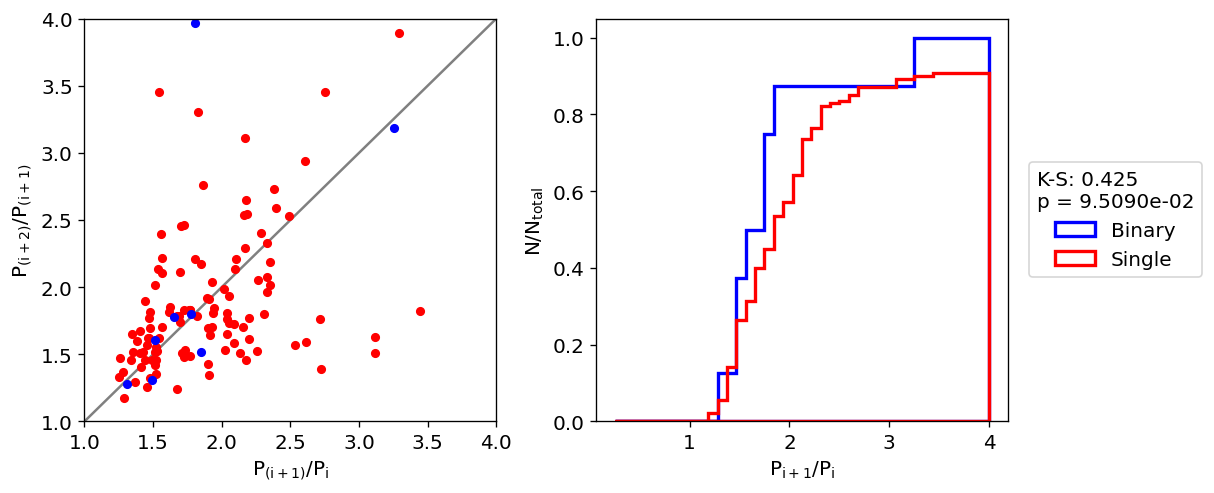

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4),# sharex = True, sharey = True, 
                        constrained_layout = True)

binary_periods = []
single_periods = []


for star, system in singles.groupby('KOI-S'):
    
    system = system.sort_values('Per')
    
    if (len(system) > 2) and (np.sum(system['Rp'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['Per'].iloc[planet+1]/system['Per'].iloc[planet],
                        system['Per'].iloc[planet+2]/system['Per'].iloc[planet+1],
                        color = 'red', s = 20, zorder = -2)
            
            single_periods.append(system['Per'].iloc[planet+1]/system['Per'].iloc[planet])


for star, system in binaries.groupby('KOI-S'):
    
    system = system.sort_values('Per')
    
    if (len(system) > 2) and (np.sum(system['Rp'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['Per'].iloc[planet+1]/system['Per'].iloc[planet],
                        system['Per'].iloc[planet+2]/system['Per'].iloc[planet+1],
                        color = 'blue', s = 20, zorder = -2)

            binary_periods.append(system['Per'].iloc[planet+1]/system['Per'].iloc[planet])




axs[0].set_xlim(0,0.32)
axs[0].set_ylim(0,0.32)


axs[0].set_xlim(1,4)
axs[0].set_ylim(1,4)


axs[0].plot([0, 4], [0, 4], color = 'gray', zorder = -10)
    
axs[0].set_xlabel('P$_\\mathrm{(i+1)}$/P$_\\mathrm{i}$')

axs[0].set_ylabel('P$_\\mathrm{(i+2)}$/P$_\\mathrm{(i + 1)}$')



axs[1].hist(binary_periods, edgecolor = 'blue', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(binary_periods))*len(binary_periods)), label = 'Binary',
            cumulative = True, fill = False, linewidth = 2)

axs[1].hist(single_periods, edgecolor = 'red', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(single_periods))*len(single_periods)), label = 'Single',
            cumulative = True, fill = False, linewidth = 2)

axs[1].set_xlabel('P$_\\mathrm{i+1}$/P$_\\mathrm{i}$')

axs[1].set_ylabel('N/N$_\\mathrm{total}$')

statistic, pvalue = ks_2samp(binary_periods, single_periods)

axs[1].legend(title = f'K-S: {round(statistic,4)}\np = ' + '{:.4e}'.format(pvalue), 
                  bbox_to_anchor=(1.05, 0.5),
                         loc='center left', borderaxespad=0.)



plt.show()

From this first plot it is clear that the CKS sample does not have many binary systems in it. In the left panel we can see 7 systems (blue dots) corresponding to those that have 2 stars, according to the Exoplanet Archive. In the right panel we can see that the K-S test shows that the distributions are indeed different, probably due to the fact that the binary system sample is very small in comparison to the single star system sample. It is important to note that given the small number of binary systems, the KS statistics should be interpreted qualitatively rather than as definitive hypothesis tests.

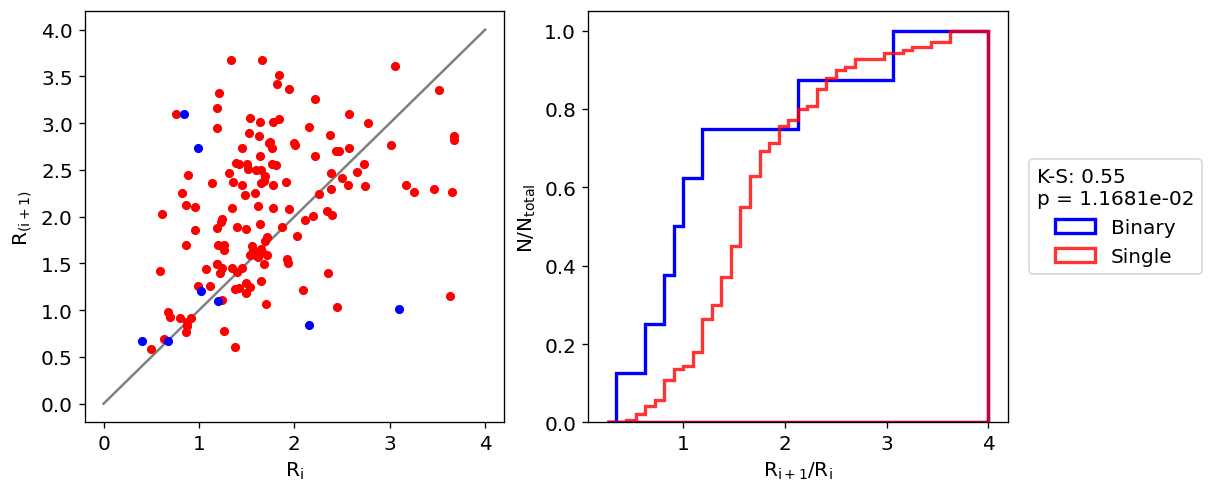

In [12]:

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4),# sharex = True, sharey = True, 
                        constrained_layout = True)
binary_rads = []
single_rads = []

for star, system in singles.groupby('KOI-S'):
    
    system = system.sort_values('Per')
    

    if (len(system) > 2) and (np.sum(system['Rp'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['Rp'].iloc[planet],
                        system['Rp'].iloc[planet+1],
                        color = 'red', s = 20, zorder = -2)

            single_rads.append(system['Rp'].iloc[planet])


for star, system in binaries.groupby('KOI-S'):
    
    system = system.sort_values('Per')
    
    if (len(system) > 2) and (np.sum(system['Rp'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['Rp'].iloc[planet],
                        system['Rp'].iloc[planet+1],
                        color = 'blue', s = 20, zorder = -2)

            binary_rads.append(system['Rp'].iloc[planet])

axs[0].plot([0, 4], [0, 4], color = 'gray', zorder = -10)
    
axs[0].set_xlabel('R$_\\mathrm{i}$')

axs[0].set_ylabel('R$_\\mathrm{(i + 1)}$')



axs[1].hist(binary_rads, edgecolor = 'blue', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(binary_rads))*len(binary_rads)), label = 'Binary',
            cumulative = True, fill = False, linewidth = 2)


axs[1].hist(single_rads, edgecolor = 'red', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(single_rads))*len(single_rads)), alpha = 0.8, label = 'Single',
            cumulative = True, fill = False, linewidth = 2)



axs[1].set_xlabel('R$_\\mathrm{i+1}$/R$_\\mathrm{i}$')
axs[1].set_ylabel('N/N$_\\mathrm{total}$')


statistic, pvalue = ks_2samp(binary_rads, single_rads)

axs[1].legend(title = f'K-S: {round(statistic,4)}\np = ' + '{:.4e}'.format(pvalue), 
              bbox_to_anchor=(1.05, 0.5),
                         loc='center left', borderaxespad=0.)


plt.show()

In this second plot, comparing the radii for consecutive planets, we can see that the binary systems are either below or above the curve, and do not follow the 1 to 1 curve that the peas in a pod systems do. This is also very noticeable in the right side plot, where both curves appear to be very different, with a KS test result of 0.55, even higher than before.

### What does the architecture of multiplanet systems with two stars look like?

Because of the small amount of binary systems already classified as peas in a pod, we can also compare the overall peas in a pod architecture (of both single and binary stars from the CKS sample, since we know that there are not enough binary systems by themselves) with those that ar classified as binary systems from the Exoplanet Archive (that is, those where sy_snum = 2).

In [13]:
exoplanetarchive_binaries = exoplanetarchive[exoplanetarchive['sy_snum'] == 2]
exoplanetarchive_binaries.fillna({'pl_rade': -1})
exoplanetarchive_binaries = exoplanetarchive_binaries.copy()

In order to increase the already small size of the sample I chose to calculate radii for those planets with only mass reported, using an empirical mass radius relation (Müller et al. 2016). This because the original peas-in-a-pod architecture comes from a transiting planet survey, which gives us radii, while other methods, like radial velocity for example, can help us constrain the mass instead.

In [14]:
def mass_radius(mass):
    if np.isnan(mass) == True:
        radius = -1
    
    elif mass <= 4.37:
        
        radius = 1.02*(mass**(0.27))
    
    elif (mass <= 127) and (mass > 4.37):
        radius = 0.56*(mass**(0.67))

    elif mass > 127:
        radius = 18.6*(mass**(-0.06))

    return radius


In [15]:
exoplanetarchive_binaries.loc[:, 'pl_rade_calc'] = exoplanetarchive_binaries['pl_masse'].apply(mass_radius)


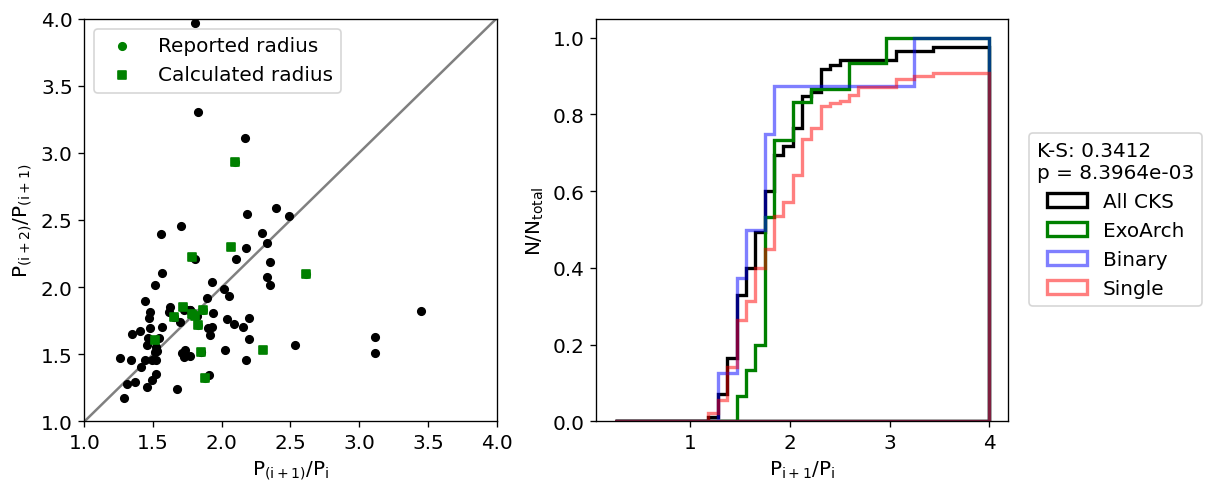

In [16]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4),# sharex = True, sharey = True, 
                        constrained_layout = True)

cks_periods = []
archive_periods = []

for star, system in cks.groupby('KOI-S'):
    
    system = system.sort_values('Per')
    
    if ((len(system)-2) > 1) and (np.sum(system['Rp'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['Per'].iloc[planet+1]/system['Per'].iloc[planet],
                        system['Per'].iloc[planet+2]/system['Per'].iloc[planet+1],
                        color = 'k', s = 20, zorder = 2)
            
            cks_periods.append(system['Per'].iloc[planet+1]/system['Per'].iloc[planet])


for star, system in exoplanetarchive_binaries.groupby('DR3_id'):
    
    system = system.sort_values('pl_orbper')
       
    if ((len(system)-2) > 1) and (np.sum(system['pl_rade'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['pl_orbper'].iloc[planet+1]/system['pl_orbper'].iloc[planet],
                        system['pl_orbper'].iloc[planet+2]/system['pl_orbper'].iloc[planet+1],
                        color = 'green', s = 20, zorder = -2)
            
            if system['pl_orbper'].iloc[planet+1]/system['pl_orbper'].iloc[planet] <= 4:

                archive_periods.append(system['pl_orbper'].iloc[planet+1]/system['pl_orbper'].iloc[planet])


for star, system in exoplanetarchive_binaries.groupby('DR3_id'):
    
    system = system.sort_values('pl_orbper')
    
    if ((len(system)-2) > 1) and (np.sum(system['pl_rade_calc'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['pl_orbper'].iloc[planet+1]/system['pl_orbper'].iloc[planet],
                        system['pl_orbper'].iloc[planet+2]/system['pl_orbper'].iloc[planet+1],
                        color = 'green', s = 20, zorder = 2, marker = 's')
            
            if system['pl_orbper'].iloc[planet+1]/system['pl_orbper'].iloc[planet] <= 4:
                archive_periods.append(system['pl_orbper'].iloc[planet+1]/system['pl_orbper'].iloc[planet])


axs[0].scatter(-1,-1,
            color = 'green', s = 20, zorder = -2, label = 'Reported radius')

axs[0].scatter(-1,-1,
            color = 'green', s = 20, zorder = 2, marker = 's', label = 'Calculated radius')



axs[0].set_xlim(1,4)
axs[0].set_ylim(1,4)


axs[0].plot([0, 4], [0, 4], color = 'gray', zorder = -10)
    
axs[0].set_xlabel('P$_\\mathrm{(i+1)}$/P$_\\mathrm{i}$')

axs[0].set_ylabel('P$_\\mathrm{(i+2)}$/P$_\\mathrm{(i + 1)}$')

axs[0].legend()

axs[1].hist(cks_periods, edgecolor = 'k', histtype = 'stepfilled', bins = 40, range = (0.25,4), 
            weights = 1/(np.ones(len(cks_periods))*len(cks_periods)), fill = False, cumulative = True, label = 'All CKS',  linewidth = 2)

axs[1].hist(archive_periods, edgecolor = 'green', histtype = 'stepfilled', bins = 40, range = (0.25,4),
            weights = 1/(np.ones(len(archive_periods))*len(archive_periods)), fill = False, cumulative = True, label = 'ExoArch',  linewidth = 2)


axs[1].hist(binary_periods, edgecolor = 'blue', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(binary_rads))*len(binary_rads)), label = 'Binary',
            cumulative = True, fill = False, linewidth = 2, alpha = 0.5)


axs[1].hist(single_periods, edgecolor = 'red', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(single_rads))*len(single_rads)), label = 'Single',
            cumulative = True, fill = False, linewidth = 2, alpha = 0.5)



axs[1].set_xlabel('P$_\\mathrm{i+1}$/P$_\\mathrm{i}$')
axs[1].set_ylabel('N/N$_\\mathrm{total}$')


statistic, pvalue = ks_2samp(cks_periods, archive_periods)

axs[1].legend(title = f'K-S: {round(statistic,4)}\np = ' + '{:.4e}'.format(pvalue), 
              bbox_to_anchor=(1.05, 0.5),
                         loc='center left', borderaxespad=0.)

plt.show()

In this figure we can see that adding calculated radii has increased the sample size to 13 planets, which is bigger than before but still a lot smaller than the full CKS sample. In the left plot the square points correspond to those with calculated radii, while the circules show the same binary systems as before. In the right side we have the cumulative distributions, and again we have included the binary and single populations from before, in the same colors as the previous section. In this case I have included the KS test comparing the full CKS distribution (black) and the binary population from the Exoplanet Archive. The value in this case is lower, indicating that the distributions might be similar, but again the sample sizes might be hindering the results.

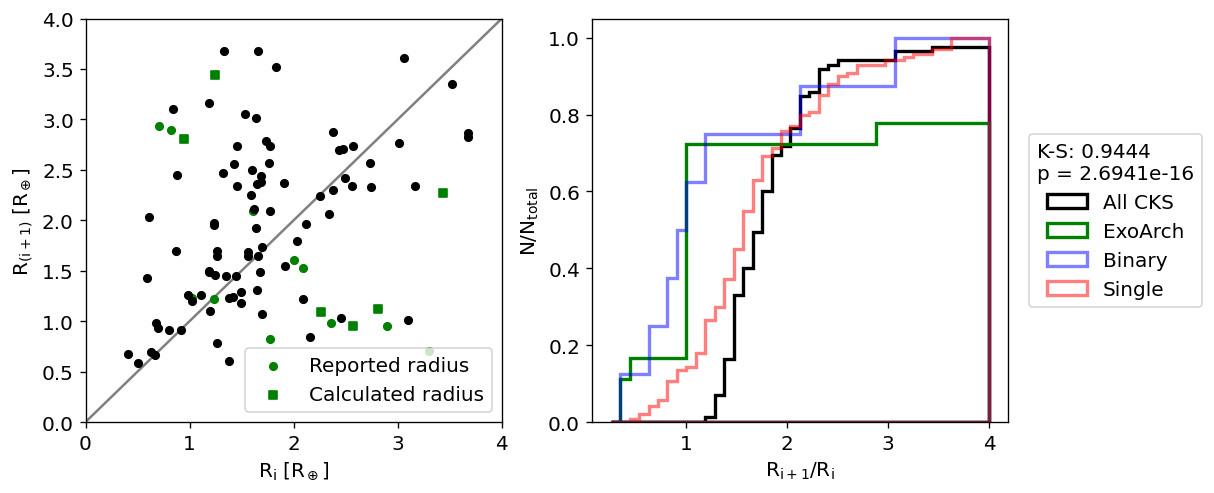

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4),# sharex = True, sharey = True, 
                        constrained_layout = True)

cks_rads = []
archive_rads = []

for star, system in cks.groupby('KOI-S'):
    
    system = system.sort_values('Per')
    
    if ((len(system)-2) > 1) and (np.sum(system['Rp'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['Rp'].iloc[planet],
                        system['Rp'].iloc[planet+1],
                        color = 'k', s = 20, zorder = 2)
            
            cks_rads.append(system['Per'].iloc[planet+1]/system['Per'].iloc[planet])


for star, system in exoplanetarchive_binaries.groupby('DR3_id'):
    
    system = system.sort_values('pl_orbper')
    
    if ((len(system)-2) > 1) and (np.sum(system['pl_rade'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['pl_rade'].iloc[planet],
                        system['pl_rade'].iloc[planet+1],
                        color = 'green', s = 20, zorder = -2)
            
            if (system['pl_rade_calc'].iloc[planet] <= 4) and (np.sum(system['pl_rade'] < 0)):

                archive_rads.append(system['pl_rade'].iloc[planet+1]/system['pl_rade'].iloc[planet])
    
for star, system in exoplanetarchive_binaries.groupby('DR3_id'):
    
    system = system.sort_values('pl_orbper')
    
    if ((len(system)-2) > 1) and (np.sum(system['pl_rade_calc'] >= 4) < 1):
        
        for planet in range(len(system)-2):
            axs[0].scatter(system['pl_rade_calc'].iloc[planet],
                        system['pl_rade_calc'].iloc[planet+1],
                        color = 'green', s = 20, zorder = -2, marker = 's')
            
            if (system['pl_rade_calc'].iloc[planet] <= 4) and (np.sum(system['pl_rade_calc'] < 0)):

                archive_rads.append(system['pl_rade_calc'].iloc[planet+1]/system['pl_rade_calc'].iloc[planet])
  
axs[0].scatter(-1,-1,
            color = 'green', s = 20, zorder = -2, label = 'Reported radius')

axs[0].scatter(-1,-1,
            color = 'green', s = 20, zorder = 2, marker = 's', label = 'Calculated radius')



axs[0].set_xlim(0,4)
axs[0].set_ylim(0,4)


axs[0].plot([0, 4], [0, 4], color = 'gray', zorder = -10)
    
axs[0].set_xlabel('R$_\\mathrm{i}$ [R$_\\oplus$]')

axs[0].set_ylabel('R$_\\mathrm{(i + 1)}$ [R$_\\oplus$]')

axs[0].legend()



axs[1].hist(cks_rads, edgecolor = 'k', histtype = 'stepfilled', bins = 40, range = (0.25,4), 
            weights = 1/(np.ones(len(cks_rads))*len(cks_rads)), fill = False, cumulative = True, label = 'All CKS',  linewidth = 2)

axs[1].hist(archive_rads, edgecolor = 'green', histtype = 'stepfilled', bins = 40, range = (0.25,4),
            weights = 1/(np.ones(len(archive_rads))*len(archive_rads)), fill = False, cumulative = True, label = 'ExoArch',  linewidth = 2)


axs[1].hist(binary_rads, edgecolor = 'blue', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(binary_rads))*len(binary_rads)), label = 'Binary',
            cumulative = True, fill = False, linewidth = 2, alpha = 0.5)


axs[1].hist(single_rads, edgecolor = 'red', histtype = 'stepfilled', bins = 40, 
            range = (0.25,4), weights = 1/(np.ones(len(single_rads))*len(single_rads)), label = 'Single',
            cumulative = True, fill = False, linewidth = 2, alpha = 0.5)



axs[1].set_xlabel('R$_\\mathrm{i+1}$/R$_\\mathrm{i}$')
axs[1].set_ylabel('N/N$_\\mathrm{total}$')


statistic, pvalue = ks_2samp(cks_rads, archive_rads)

axs[1].legend(title = f'K-S: {round(statistic,4)}\np = ' + '{:.4e}'.format(pvalue), 
              bbox_to_anchor=(1.05, 0.5),
                         loc='center left', borderaxespad=0.)

plt.show()

In the same way as before we can also compare the radii, and here it is possible to see that the points follow the same trend as above, being either above or below the curve, and not following the same distribution as the CKS sample. In the right side this is shown by the very high value of the KS test, of 0.94, and the fact that the distributios do look very different. 

### <u>Exploring other options</u>

Overall, it seems like even at these small sized samples it is possible to recover some differences between the distributions, which would make sense if we consider that the presence of an external perturber can alter the architecture of the planetary system. This can not only be seen in the dynamical evolution of a system, which we can maybe probe through the separation of the planets, but also the formation scenarios, which are probably more related to the sizes of planets we can find, and how regular these sizes are. 

Because of this, just as a last resort, we can compare other properties, like eccentricities and inclinations for these systems. For this I will use the same crossmatch between the CKS catalogue and the Exoplanet Archive.

In [18]:
exoplanetarchive_starinfo = exoplanetarchive.filter(['gaia_dr3_id', 'DR3_id', 'sy_snum', 'pl_orbeccen',
                                                     'pl_orbincl', 'pl_orbper', 'sy_pnum', 'pl_orbsmax']).drop_duplicates()

cks_x_archive = cks.merge(exoplanetarchive_starinfo, left_on='dr3_id', right_on='DR3_id')

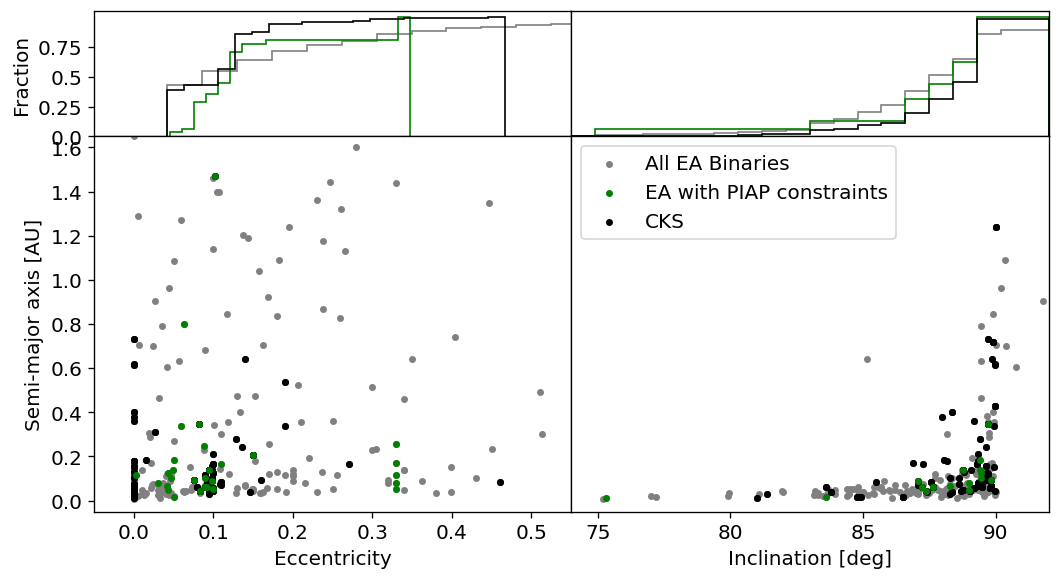

In [19]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9,5), width_ratios = [3,3], height_ratios = [1,3],
                        gridspec_kw = {'hspace':0, 'wspace': 0}, 
                       )

sep_cks = []
eccen_cks = []
eccen_ea = []
sep_ea = []
inc_cks = []
inc_ea = []


for i,star in enumerate(np.unique(cks['KOI-S'])):

    system_cks = cks_x_archive.loc[cks_x_archive['KOI-S'] == star].sort_values(by = 'Per')
    
    if ((len(system_cks)-2) > 1) and (np.sum(system_cks['Rp'] >= 4) < 1):
            
        axs[1][0].scatter(system_cks['pl_orbeccen'], system_cks['pl_orbsmax'], color = 'k', s = 10)

        axs[1][1].scatter(system_cks['pl_orbincl'], system_cks['pl_orbsmax'], color = 'k', s = 10)

        sep_cks.append(np.asarray(system_cks['pl_orbsmax'])[~np.isnan(np.asarray(system_cks['pl_orbsmax']))])        
        eccen_cks.append(np.asarray(system_cks['pl_orbeccen'])[~np.isnan(np.asarray(system_cks['pl_orbeccen']))])
        inc_cks.append(np.asarray(system_cks['pl_orbincl'])[~np.isnan(np.asarray(system_cks['pl_orbincl']))])



for i,star in enumerate(np.unique(exoplanetarchive_binaries['DR3_id'])):

    system = exoplanetarchive_binaries.loc[exoplanetarchive_binaries['DR3_id'] == star].sort_values(by = 'pl_orbper')
    
    if ((len(system)-2) > 1) and (np.sum(system['pl_rade_calc'] >= 4) < 1):
        
        axs[1][0].scatter(system['pl_orbeccen'], system['pl_orbsmax'], color = 'green', s = 10)

        axs[1][1].scatter(system['pl_orbincl'], system['pl_orbsmax'], color = 'green', s = 10)

        sep_ea.append(np.asarray(system['pl_orbsmax'])[~np.isnan(np.asarray(system['pl_orbsmax']))])                
        eccen_ea.append(np.asarray(system['pl_orbeccen'])[~np.isnan(np.asarray(system['pl_orbeccen']))])
        inc_ea.append(np.asarray(system['pl_orbincl'])[~np.isnan(np.asarray(system['pl_orbincl']))])



axs[1][0].scatter(exoplanetarchive_binaries['pl_orbeccen'], exoplanetarchive_binaries['pl_orbsmax'], color = 'gray', s = 10, zorder = -10)

axs[1][1].scatter(exoplanetarchive_binaries['pl_orbincl'], exoplanetarchive_binaries['pl_orbsmax'], color = 'gray', s = 10, zorder = -10)



axs[0][0].hist(exoplanetarchive_binaries['pl_orbeccen'][~np.isnan(np.asarray(exoplanetarchive_binaries['pl_orbeccen']))], fill = False, histtype = 'step', color = 'gray', bins = 20,
               weights = np.ones(len(exoplanetarchive_binaries['pl_orbeccen'][~np.isnan(np.asarray(exoplanetarchive_binaries['pl_orbeccen']))]))/len(exoplanetarchive_binaries['pl_orbeccen'][~np.isnan(np.asarray(exoplanetarchive_binaries['pl_orbeccen']))]),
               
               cumulative = True)

axs[0][1].hist(exoplanetarchive_binaries['pl_orbincl'][~np.isnan(np.asarray(exoplanetarchive_binaries['pl_orbincl']))], fill = False, histtype = 'step', color = 'gray', bins = 20,
               weights = np.ones(len(exoplanetarchive_binaries['pl_orbincl'][~np.isnan(np.asarray(exoplanetarchive_binaries['pl_orbincl']))]))/len(exoplanetarchive_binaries['pl_orbincl'][~np.isnan(np.asarray(exoplanetarchive_binaries['pl_orbincl']))]),
               cumulative = True, range = (74,92))



axs[0][0].hist(np.concatenate(eccen_ea), fill = False, histtype = 'step', color = 'green', bins = 20,
               weights = np.ones(len(np.concatenate(eccen_ea)))/len(np.concatenate(eccen_ea)),
               cumulative = True)

axs[0][1].hist(np.concatenate(inc_ea), fill = False, histtype = 'step', color = 'green', bins = 20,
               weights = np.ones(len(np.concatenate(inc_ea)))/len(np.concatenate(inc_ea)),
               cumulative = True, range = (74,92))



axs[0][0].hist(np.concatenate(eccen_cks), fill = False, histtype = 'step', color = 'k', bins = 20,
               weights = np.ones(len(np.concatenate(eccen_cks)))/len(np.concatenate(eccen_cks)),
               cumulative = True)

axs[0][1].hist(np.concatenate(inc_cks), fill = False, histtype = 'step', color = 'k', bins = 20,
               weights = np.ones(len(np.concatenate(inc_cks)))/len(np.concatenate(inc_cks)),
               cumulative = True, range = (74,92))



axs[1][1].scatter(-1,-1,
            color = 'gray', s = 10, zorder = -2, label = 'All EA Binaries')
axs[1][1].scatter(-1,-1,
            color = 'green', s = 10, zorder = -2, label = 'EA with PIAP constraints')
axs[1][1].scatter(-1,-1,
            color = 'k', s = 10, zorder = -2, label = 'CKS')
axs[1][1].legend()

axs[0][1].set_yticks([])
axs[1][1].set_yticks([])

axs[0][0].set_xticks([])
axs[0][1].set_xticks([])


axs[0][0].set_xlim(-0.1, 0.55)
axs[1][0].set_xlim(-0.05, 0.55)
axs[1][0].set_ylim(-0.05, 1.65)
axs[1][1].set_ylim(-0.05, 1.65)

axs[0][1].set_xlim(74,92)
axs[1][1].set_xlim(74,92)

axs[0][0].set_ylabel('Fraction')

axs[1][0].set_ylabel('Semi-major axis [AU]')
axs[1][0].set_xlabel('Eccentricity')
axs[1][1].set_xlabel('Inclination [deg]')

axs[0][0].set_yticks(np.linspace(0,0.75, 4), np.linspace(0,0.75, 4))

plt.tight_layout()
plt.show()

In this last figure we are comparing the inclination and eccentricity as a function of orbital separation for planets in the CKS catalogue (black), the Exoplanet Archive binaries (gray), and those binaries that follow the constraints mentioned along this project, that is, more than 3 planets with radii smaller than 4 Rearth. In the top panels I have included the distributions of these three samples as functions of eccentricity and inclination. From this figure we can see that out of all the binary systems, very few comply with the peas-in-a-pod constraints, in most cases because the number of planets is smaller than 3. That result in itself may indicate that under the presence of a binary planets tend to be perturbed and accreted or ejected from the system (Ávila-Bravo et al. 2025); this of course, ends up depending on the actual configuration of the system, meaning both the planetary architecture and the orbital parameters of the binary companion. 

With respect to the sample of binary systems that do follow the peas-in-a-pod constraints, it seems like they are located in the same region in the parameter space as the original CKS sample. The distributions at the top plots also seems to be overall similar, with the distinction that the full exoplanet archive binary sample expands to higher values of eccentricity than the 'peas-in-a-pod' binary systems. This may indicate that the presence of a binary companion might not allow eccentric planets in multiplanet systems with peas-in-a-pod architectures to exist in stable orbits. However, we still don't have a large enough sample for these conclusions to be statistically significant. It is also important to note that because of how these systems are detected and analysed, there is a lack of information since not all of them have follow-ups both in transit and radial velocity surveys. 

_________________________________

## Conclusions

In this project, we investigated whether the peas-in-a-pod (PIAP) architecture, characterized by correlated planet sizes and regular orbital spacing in multiplanet systems, is preserved in stellar binary systems. Using the California Kepler Survey as a reference sample and combining it with the Exoplanet Archive and Gaia DR3 multiplicity information, we compared the architecture of multiplanet systems around single and binary stars. As a baseline, we successfully recovered the characteristic PIAP trends within the CKS sample. Planets in single-star systems exhibit positively correlated radii and regular spacing in orbital periods, consistent with previous studies. Consecutive planet pairs tend to lie close to the one-to-one relation in radius, and period ratios cluster around a narrow range, confirming that the chosen methodology is able to recover these expected and well-known features.

When separating the CKS systems by stellar multiplicity, we found that only a very small fraction of known PIAP systems are binaries. Nonetheless, within the limited binary sample, the distributions of period and radius ratios appear qualitatively different from those of single-star systems, with increased scatter and weaker correlations. To mitigate small-number statistics, we attempted to expand the binary sample using the Exoplanet Archive and inferred planet radii from masses where necessary via an empirical mass–radius relation. Even with this augmentation, multiplanet systems in binaries rarely satisfy the classical PIAP constraints. Their period-ratio and radius-ratio distributions differ from those of the CKS population, suggesting that the presence of a stellar companion may disrupt the formation or long-term preservation of tightly ordered planetary architectures.

Finally, an exploratory comparison of eccentricities and inclinations suggests that binary systems populate a broader region of parameter space, particularly at higher eccentricities. In contrast, the subset of binary systems that do resemble PIAP architectures occupy regions similar to those of single-star systems. This suggests that while PIAP-like architectures can exist in binaries, they likely require specific configurations—such as wide separations or low mutual inclinations—to remain dynamically stable. Moreover, we find that most systems fail the PIAP constraint due to the number of planets being smaller than three, which can also hint at the effects of having a binary companion around a planet-hosting star.

Overall, our results suggest that stellar multiplicity plays an important role in shaping multiplanet system architectures. While PIAP systems are common around single stars, they are comparatively rare and less orderly in binaries, consistent with scenarios in which dynamical perturbations from a stellar companion alter planet formation and evolution. However, the statistical significance of these conclusions is limited by the small number of well-characterized binary multiplanet systems. Future surveys combining Gaia astrometry, transit observations, and radial-velocity follow-up will be essential to quantify the impact of binarity on planet population architectures more robustly.